In [ ]:
from tgp.experiments import get_dataset
import GPyOpt
import numpy as np
%matplotlib inline

In [39]:
df = get_dataset()

In [40]:
# We can also use tgp.experiments.get_single_matern to do
# some of the work in this demo notebook. But here we show the full
# sequence of steps to optimise a problem.

In [41]:
# First, we define our kernel.
from tgp.matern_kernels import MaternKernel32

In [42]:
# To do optimisation, we'll need a function that creates a kernel.
def get_kernel(theta):
    kernel = MaternKernel32(np.array([theta[0]]), theta[1])
    return kernel

In [43]:
# We'll also need some bounds to search in:
bounds = [{'name': 'l', 'type': 'continuous', 'domain': (0.1, 10.)},
          {'name': 'sd', 'type': 'continuous', 'domain': (0.01, 2.)}]


In [44]:
# Now, let's get our data
# Use 2016 & 2017 to optimise
df = df.query("""
    start_date >= "2016-1-1" & start_date < "2017-12-31"
""")

winners = df['winner'].values
losers = df['loser'].values
days_since_start = (df['start_date'] - df['start_date'].min()).dt.days.values

In [45]:
from tgp.gp_predictor import GPPredictor

In [46]:
# We need a function we can minimise using GPy. 
# Let's define that here.
def to_minimise(theta, unwrap=True):
    
    if unwrap:
        # GPy has an extra level of wrapping for some reason
        theta = theta[0]
    
    # Get our kernel
    kernel = get_kernel(theta)
    
    # Fit the model
    predictor = GPPredictor(kernel)
    predictor.fit(winners, losers, days_since_start)
    
    # Now we can calculate the log marginal likelihood
    log_marginal_lik = predictor.calculate_log_marg_lik()
    
    # Return it with its sign flipped so we can _minimise_
    return -log_marginal_lik

In [47]:
# At this point, we can use any minimisation routine (e.g. random search).

# Now we can define a GPy "problem"
# Note: this automatically runs 5 initial runs.
problem = GPyOpt.methods.BayesianOptimization(to_minimise, bounds)

-40946.706785870716
-40974.77343289739
-20380.809871564696
-42509.284688516615
-42498.854543861984


In [48]:
# Run a further 10 times
problem.run_optimization(10)

-46731.706664370824
-40878.18345264076
-42237.63444047288
-41289.36884421163
-40019.2308434898
-44639.42541111102
-41709.19308086883
-42116.18299561516
-41586.25875895837
-39470.910257226315


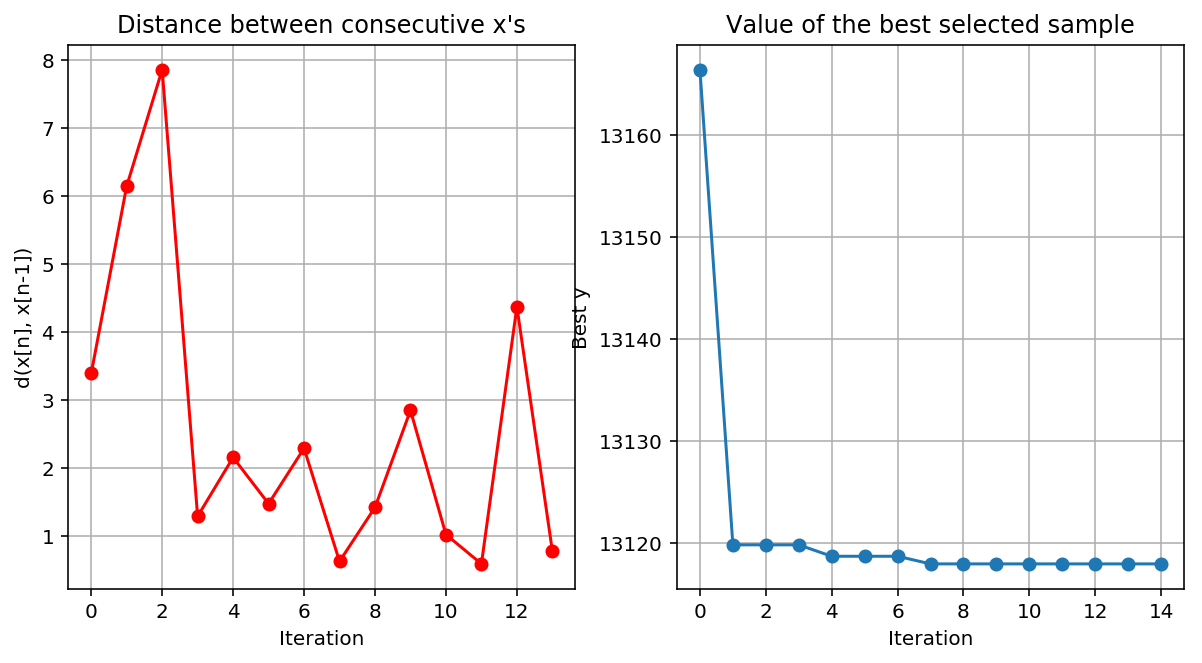

In [49]:
# We can take a look at the convergence results
problem.plot_convergence()

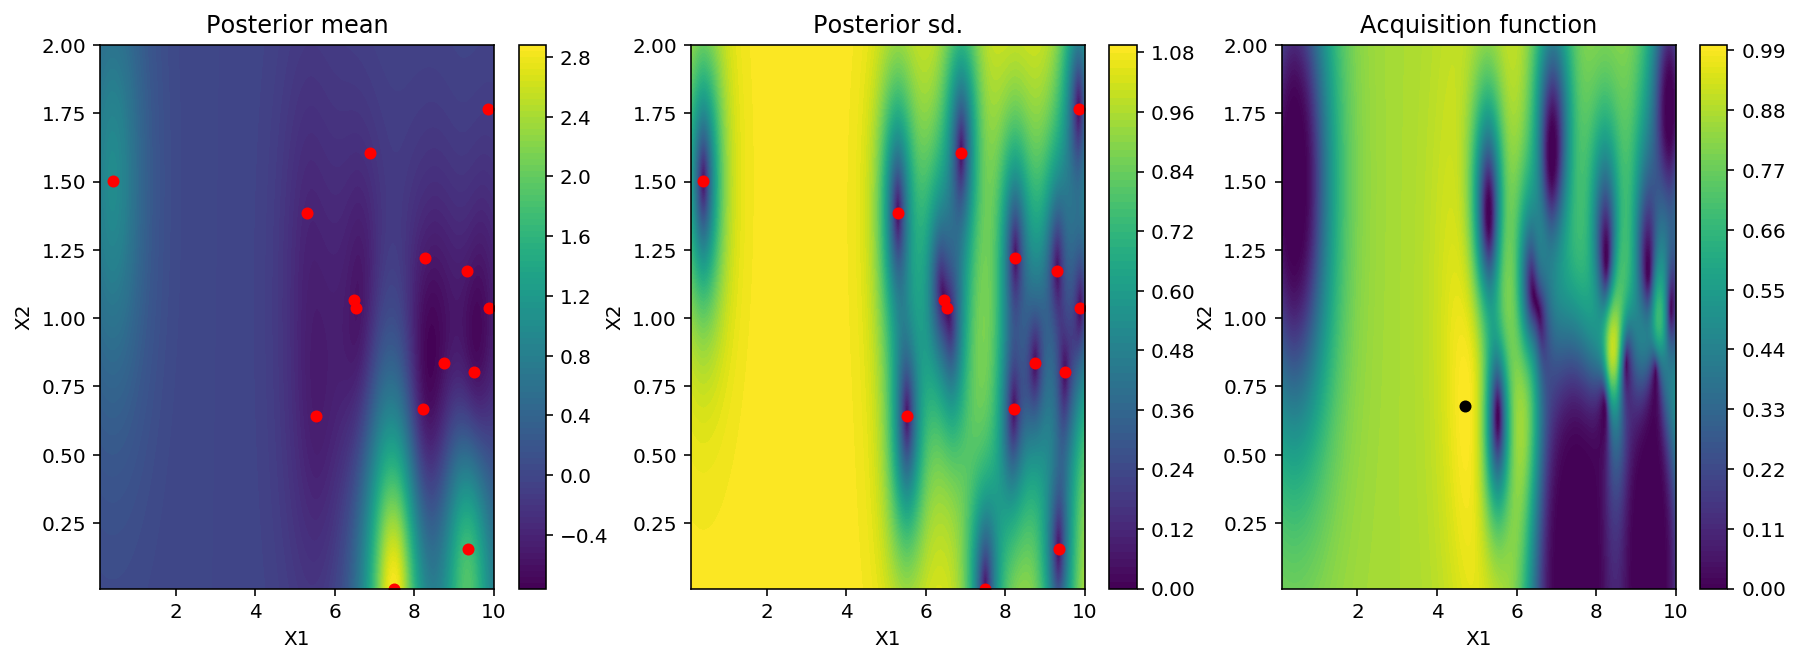

In [50]:
# We can also take a look at what the inferred loss surface looks like
# (at least for this 2D example)
problem.plot_acquisition()

In [54]:
# We can get the best x found
problem.x_opt

array([8.74777525, 0.83541734])

In [55]:
# And the best function value:
problem.fx_opt

13117.937592071568